# Hard Drive Failure

### Objective:

Explore hard drive failure data and provide device failure analysis using the Kaplan-Meier model and the Cox Hazard Model.  

### Data:

This is data provided by BackBlaze.  They are an online file backup and storage company. They have posted their log files of hard drives.  There are 256 S.M.A.R.T statistics recorded for each drive along with model numbers, makes and datestamps.

### Data Prep:

Because this data is large, 3.5gb for 2 years.  I have ran the first part on my system and uploaded a smaller simpler table of the values that are important for the model.  The below script has taken the 3.5gb and made it a 5.2mb file that can be followed using ipython.  The script will take the S.M.A.R.T. value number 9 which is a count of the numbers it is powered on.

First Import Dependencies:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import lifelines as sa
import glob, os
from collections import OrderedDict
from lifelines.utils import concordance_index, k_fold_cross_validation
import patsy as pt
from datetime import datetime
from pylab import rcParams
from sklearn.preprocessing import LabelEncoder, Imputer
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

## __Do not run, as the files are too large.  In place to show work.__

In [ ]:
os.chdir("C:\\Users\\Andrew\\Downloads\\hdd\\")

allFiles = glob.glob("*.csv")
df = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0, usecols=[0, 1, 2, 3,4, 20])
    list_.append(df)
df = pd.concat(list_)
df.reset_index(inplace=True)

os.chdir("C:\\Users\\Andrew\\Documents")

df["mindate"] = df["date"].groupby(df["serial_number"]).transform('min')
df["maxdate"] = df["date"].groupby(df["serial_number"]).transform('max')
df["minhours"] = df["smart_9_raw"].groupby(df["serial_number"]).transform('min')
df["maxhours"] = df["smart_9_raw"].groupby(df["serial_number"]).transform('max')
df["nrec"] = df["date"].groupby(df["serial_number"]).transform('count')

df = df[["date", "serial_number","model","capacity_bytes","mindate","maxdate",
        "minhours", "maxhours","nrec","failure"]]

df = df.sort_values("failure",ascending=False)
df = df.drop_duplicates(["serial_number"],keep="first")
df.reset_index(inplace=True)

#Save off file
df.to_csv("HDD-log.csv", index=False)

### Clean the Data:

The first process is to bring the data in and get a look and feel for it.  

In [49]:
df = pd.read_csv("https://raw.githubusercontent.com/AKaszpurenko/ExampleWork/master/HDD-log.csv")
df.head()


,index,date,serial_number,model,capacity_bytes,mindate,maxdate,minhours,maxhours,nrec,failure
0,14109811,2014-10-02,S1F04ZNE,ST3000DM001,3.000593e+12,2013-04-10,2014-10-07,7993.0,21072.0,490,1.0
1,3289347,2013-10-24,S1F0BF5S,ST3000DM001,3.000593e+12,2013-04-10,2013-10-24,6545.0,11231.0,142,1.0
2,9065502,2014-05-12,Z3016NNT,ST4000DM000,4.000787e+12,2014-02-26,2014-05-12,12.0,1783.0,76,1.0
3,12257298,2014-08-13,S1F030WE,ST3000DM001,3.000593e+12,2013-04-10,2014-09-11,9524.0,21977.0,461,1.0
4,12709878,2014-08-25,W1F028MX,ST3000DM001,3.000593e+12,2013-04-10,2014-08-25,5194.0,17236.0,446,1.0


Each row reperesents one unique hard drive and the information we have about it and what it's past history was.

The columns are as follows:
* index = a unique row number
* date = date
* serial_number = Serial number of the hard drive
* model = Model of hard drive
* cabacity_bytes = this is capacity in bytes
* minmdate = the earliest date we have records of this hard drive
* maxdate = the latest date we have records of this hard drive
* minhours = the shortest amount of hours we have on record for this drive (S.M.A.R.T. valeu #9)
* maxhours = the max amount of hours we have on record for this drive (S.M.A.R.T. valeu #9)
* nrec = number of records
* failure = 1 => Failed, 0 => Still working

Note that the raw data that was used to compute these logs was from 1-1-13 to 12-31-14 (2 years), so some drives started up before this and lasted well past the 2 year cut off we have of this data.

In [50]:
#check for anything odd with failed
df["failure"].value_counts()

0.0    46177
1.0     2930
Name: failure, dtype: int64

In [51]:
#check for any hard drive that is just too small
df["capacity_bytes"].value_counts()



4.000787e+12    26250
3.000593e+12    12394
2.000399e+12     5259
1.500302e+12     3106
1.000205e+12      728
5.001079e+11      392
6.001175e+12      317
1.600419e+11      252
3.200729e+11      146
8.002636e+10      131
2.500594e+11      127
6.003326e+17        2
1.194001e+12        1
2.500000e+11        1
1.073493e+17        1
Name: capacity_bytes, dtype: int64

In [25]:
#adjust to TB size and also round
df["capacity"] = df["capacity_bytes"].apply(lambda x: (round(x/1000000000000,2)))

#drop hdd that are too small of records or too large
df = df.loc[(df['capacity']<6.5) & (df['capacity']>1.5)]
df.groupby(["capacity"]).size()

capacity
2.0     5259
3.0    12394
4.0    26250
6.0      317
dtype: int64

In [26]:
#Create the make/model of the drives
df["make"] = df["model"].apply(lambda x:x.split()[0])
df["model"] = df["model"].apply(lambda x: x.split()[1] if len(x.split())>1
else x)
df.groupby(["make","model"]).size()



make          model          
HGST          HDS5C4040ALE630        6
              HDS724040ALE640       42
              HMS5C4040ALE640     7166
              HMS5C4040BLE640     3115
Hitachi       HDS5C3030ALA630     4651
              HDS5C3030BLE630        1
              HDS5C4040ALE630     2719
              HDS722020ALA330     4774
              HDS723020BLA642       11
              HDS723030ALA640     1046
              HDS723030BLE640       10
              HDS724040ALE640        1
ST2000DL001   ST2000DL001           12
ST2000DL003   ST2000DL003           16
ST2000DM001   ST2000DM001            8
ST2000VN000   ST2000VN000            5
ST3000DM001   ST3000DM001         4703
ST32000542AS  ST32000542AS         385
ST320005XXXX  ST320005XXXX          17
ST33000651AS  ST33000651AS         351
ST4000DM000   ST4000DM000        12976
ST4000DX000   ST4000DX000          180
ST6000DX000   ST6000DX000           45
TOSHIBA       DT01ACA300            60
WDC           WD20EFRX            

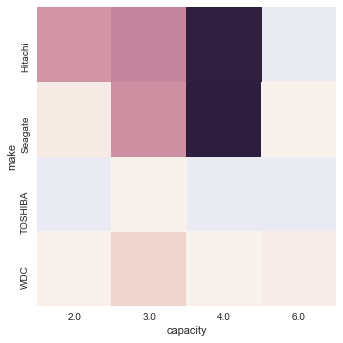

In [27]:
#Create the Seagate make and Hitachi
df["make"] = df["make"].apply(lambda x:"Seagate" if x[:2]== "ST" else x)
df.loc[df["make"] == "HGST","make"] = "Hitachi"

#Visual inspection of the data
gp = df.groupby(["make","capacity"]).size().unstack()
sb.heatmap(gp, mask=pd.isnull(gp), robust=True, square=True,cbar=False)

Toshiba has very little presence, taking out of the data

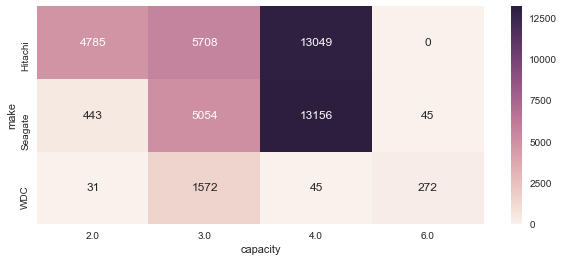

In [28]:
#Shrink to just Hitachi, Seagate, WD
df = df.loc[df["make"].isin(["Hitachi", "Seagate", "WDC"])]

#visual inspection of date start and ending
df["mindate"] = pd.to_datetime(df["mindate"])
df["maxdate"] = pd.to_datetime(df["maxdate"])
df['mindateym'] = df['mindate'].apply(lambda x: x.strftime('%Y%m'))
df['maxdateym'] = df['maxdate'].apply(lambda x: x.strftime('%Y%m'))

#Grouping by Make and Capacity
gp = df.groupby(["make","capacity"]).size().unstack()
gp[pd.isnull(gp)]=0
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,4)
                         , squeeze=False, sharex=True, sharey=True)
sb.heatmap(gp, annot=True, fmt='.0f', ax=axes[0,0])



In [32]:
gp = df.groupby(["make","capacity","failure"]).size().unstack()
gp["proportion"] = gp[1]/ gp.sum(axis=1)
gp.reset_index(inplace=True)
gp.head(10)

failure,make,capacity,0.0,1.0,proportion
0,Hitachi,2.0,4705.0,80.0,0.016719
1,Hitachi,3.0,5626.0,82.0,0.014366
2,Hitachi,4.0,12959.0,90.0,0.006897
3,Seagate,2.0,391.0,52.0,0.117381
4,Seagate,3.0,3426.0,1628.0,0.322121
5,Seagate,4.0,12869.0,287.0,0.021815
6,Seagate,6.0,45.0,NaN,NaN
7,WDC,2.0,29.0,2.0,0.064516
8,WDC,3.0,1500.0,72.0,0.045802
9,WDC,4.0,45.0,NaN,NaN


Clean data set, now to use two different models on the dataset.

# Kaplan-Meier Model

The Kaplan-Meier model gives a maxium-likelihood estimate of survival function.

First step is to define the functions:

In [33]:
#Kaplan Meier Model
def  estimate_cond_mean(S):
    """Quick est of conditional mean lifetime"""
    fstar = -S.diff() / (1-S.iloc[-1.0])
    Sstar = (S-S.iloc[-1,0]) / (1-S.iloc[-1,0])
    llstarr = fstar/ Sstar

    llstar[pd.isnull(llstar)] = 0
    llstar = llstar[np.isfinite(llstar)]
    llstarcs = llstar.cumsum().reset_index()
    llstarcs["timelinediff"] = np.append(llstarcs["timeline"].diff().value[1:],0)
    llstarcs["auc"] = llstarcs["timelinediff"]*llstarcs["KM_estimate"]
    return np.nansum(llstarcs["auc"]).round()

#Generic plotting
def plot_km(km, axes, suptxt='', subtxt='', i=0, j=0, arws=[], xmax=0, smlfs=10):

    ax = km.plot(ax=axes[i,j], title=subtxt, legend=False)
    plt.suptitle(suptxt, fontsize=14)
    axes[i,j].axhline(0.5, ls='--', lw=0.5)
    axes[i,j].annotate('half-life', fontsize=smlfs, color='b'
            ,xy=(0,0.5), xycoords='axes fraction'
            ,xytext=(10,4), textcoords='offset points')

    S = km.survival_function_
    hl = S.loc[S['KM_estimate']<0.5,'KM_estimate'].head(1)
    if len(hl) == 1:
        axes[i,j].annotate('{:.0f}'.format(hl.index[0]), fontsize=smlfs
            ,xy=(0,0.5), xycoords='axes fraction'
            ,xytext=(10,-12), textcoords='offset points', color='b')

    for pt in arws:
        tml = km.survival_function_[:pt].tail(1)
        plt.annotate('{:.1%}\n@ {:.0f}hrs'.format(tml['KM_estimate'].values[0],tml.index.values[0])
                ,xy=(tml.index.values,tml['KM_estimate'].values), xycoords='data'
                ,xytext=(6,-50), textcoords='offset points', color='#007777', fontsize=smlfs
                ,arrowprops={'facecolor':'#007777', 'width':2})

    ax.set_ylim([0,1])
    ax.set_xlim([0,xmax])




###  All hard drives Failure chart

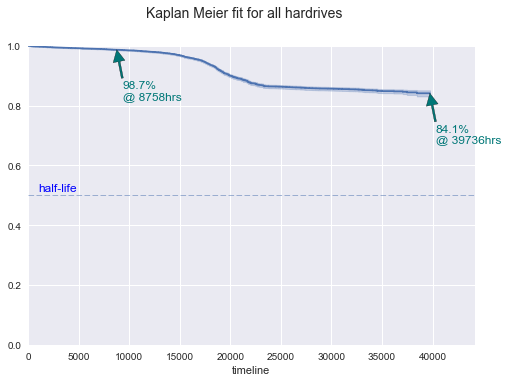

In [34]:
#All hard drives Failure rate
fig, axes = plt.subplots(nrows=1, ncols=1
                         ,squeeze=False, sharex=True, sharey=True)
km = sa.KaplanMeierFitter()
km.fit(durations=df['maxhours'], event_observed=df['failure'])
plot_km(km, axes, xmax=df.shape[0], arws=[8760, 43830]
        ,suptxt='Kaplan Meier fit for all hardrives', smlfs=12)

### Failure by Make

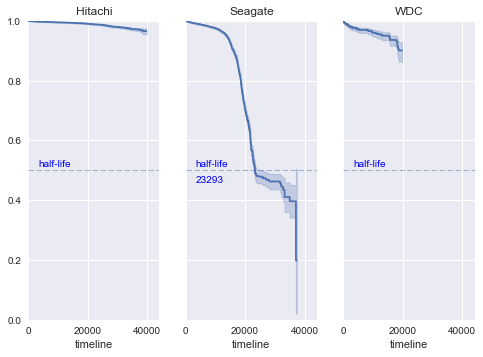

In [42]:
#Lifetime by Make
fig,axes = plt.subplots(nrows=1, ncols=len(df["make"].value_counts()),
                         squeeze=False, sharex=True, sharey=True)
for j, mfr in enumerate(np.unique(df["make"])):
    dfsub = df.loc[df["make"]==mfr]
    km = sa.KaplanMeierFitter()
    km.fit(durations=dfsub["maxhours"], event_observed=dfsub["failure"])
    plot_km(km, axes, j=j, subtxt=mfr, xmax=df.shape[0])




### Failure by Make and Capacity

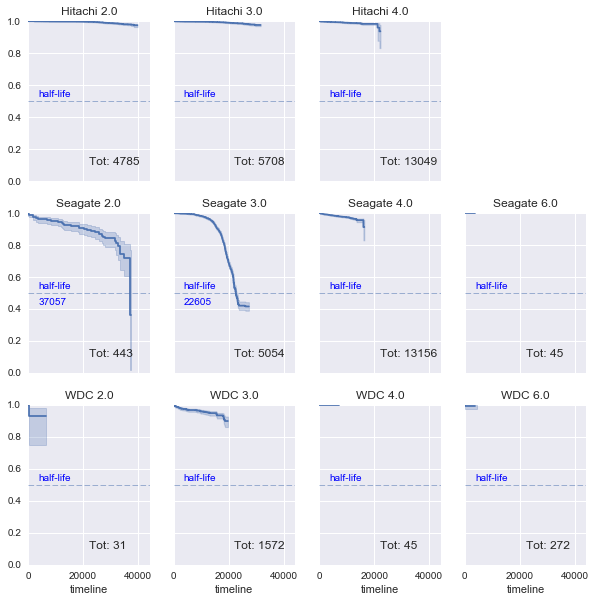

In [45]:
fig, axes = plt.subplots(nrows=len(df['make'].value_counts())
                         ,ncols=len(df['capacity'].value_counts())
                         ,squeeze=False, sharex=True, sharey=True, figsize=(10,10))

for i, mfr in enumerate(np.unique(df['make'])):
    for j, cap in enumerate(np.unique(df['capacity'])):
        dfsub = df.loc[(df['make']==mfr) & (df['capacity']==cap)]
        if dfsub.shape[0]!=0:
            km = sa.KaplanMeierFitter()
            km.fit(durations=dfsub['maxhours'], event_observed=dfsub['failure'])
            plot_km(km, axes, i=i, j=j, subtxt='{} {}'.format(mfr, cap), xmax=df.shape[0])
            axes[i,j].annotate('Tot: {}'.format(dfsub.shape[0]), xy=(0.5,0.1), xycoords='axes fraction')
        else:
            axes[i,j].axis('off')

### Examination of 3TB capacity by make

This is probably the most illuminating chart.  The 2TB & 3TB Seagate drives clearly have something wrong with them after about 2years.

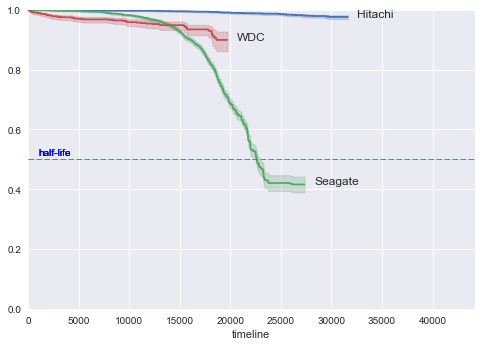

In [46]:
#Just looking at 3TB harddrives by make
dd = OrderedDict()
fig, axes = plt.subplots(nrows=1, ncols=1, squeeze=False, sharex=True, sharey=True)

for j, mfr in enumerate(np.unique(df["make"])):
    dd[mfr]= {8760:"",17520:"",26280:""}
    dfsub = df.loc[(df["make"]==mfr) & (df["capacity"]==3.0)]
    km = sa.KaplanMeierFitter()
    km.fit(durations=dfsub["maxhours"], event_observed=dfsub["failure"])
    ax = km.plot(ax=axes[0,0], legend=False)
    axes[0,0].axhline(0.5, ls='--', lw=0.5)
    axes[0,0].annotate('half-life', xy=(0,0.5), xycoords='axes fraction'
                ,xytext=(10,4), textcoords='offset points', color='b', fontsize=10)
    ax.set_ylim([0,1])
    ax.set_xlim([0,df.shape[0]])
    fnlS = km.survival_function_.iloc[-1:, :]
    axes[0,0].annotate('{}'.format(mfr), xy=(fnlS.index.values[0],fnlS.values[0][0])
                       ,xycoords='data', fontsize=12
                       ,xytext=(10,0), textcoords='offset points')


We can see that in nearly 22k hours (2.6yrs), 50% of Seagate 3 TB hard drives we would expect to fail. Compare this with 98% of Hitachi drives still working after 2.6yrs.

# Cox Hazard Model

The Cox Proportional Hazard model predicts the survival or hazard rate at each point in time.  This gives a semi-parametric method for estimating the hazard function against the covariates.

Convergence completed after 7 iterations.


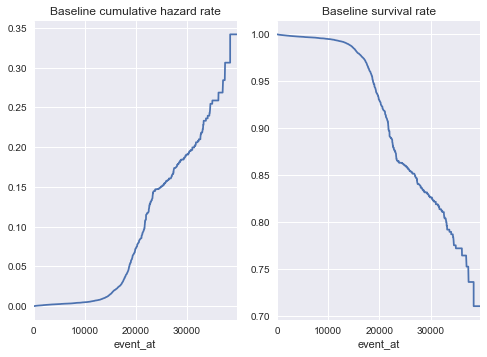

In [47]:
#Cox Hazard Model
modelspec = "make + capacity"
dft = pt.dmatrix(modelspec, df, return_type="dataframe")
design_info = dft.design_info
dft = dft.join(df[["maxhours","failure"]])

del dft["Intercept"]
cx = sa.CoxPHFitter()
cx.fit(df=dft, duration_col='maxhours', event_col='failure'
           ,show_progress=True, include_likelihood=True)

fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False, sharex=True)
cx.baseline_cumulative_hazard_.plot(ax=axes[0,0], legend=False
                ,title='Baseline cumulative hazard rate')
cx.baseline_survival_.plot(ax=axes[0,1], legend=False
                ,title='Baseline survival rate')

In [19]:
cx.summary

,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
make[T.Seagate],3.30611,27.278814,0.074292,44.501590,0.000000e+00,3.160469,3.451752
make[T.WDC],2.93444,18.810967,0.136854,21.442083,5.413569e-102,2.666152,3.202728
capacity,0.52030,1.682532,0.053752,9.679650,3.679745e-22,0.414925,0.625675
